In [29]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from scipy import stats
import math 
import statistics 
from scipy.integrate import quad
import seaborn as sns
from scipy.stats import chi2, t, f, norm

In [30]:
N = 50 # размерность выборки
p = 6 # количество признаков, 5 факторов и отклик
coef = np.array([3, -2, 1, 1, -1])

In [31]:
data = np.array([np.random.uniform(low = -1.0, high = 1.0, size = 5) for i in range(N)])
target = np.array([np.random.normal(2 + np.sum(i * coef), 1.5) for i in data])

# A - мультиколлинеарность

In [32]:
R_2_res = []
for i in range(5):
    psi = np.ones((N,1))
    psi = np.hstack([psi, np.delete(data, i, 1)])
    y = data[:,i]
    F = psi.T @ psi
    F_1 = np.linalg.inv(F)
    beta = F_1@psi.T @ y
    rss = (y-psi @ beta).T @ (y-psi @ beta)
    tss = np.sum((y-y.mean())**2) 
    R_2_res.append(1-rss/tss)

In [33]:
print(R_2_res)
print('значения < 0.7 => слабая зависимость')

[0.01500550131378986, 0.10587981054215145, 0.10896798362566606, 0.07755936911153971, 0.07658822004337462]
значения < 0.7 => слабая зависимость


# B - Определить уравнение лин. регр. и проверить значимость коэф.

In [34]:
psi = np.ones((N,1))
psi = np.hstack([psi, data])

F = psi.T @ psi
F_1 = np.linalg.inv(F)
beta = F_1@psi.T @ target
rss = (target - psi @ beta).T @ (target-psi @ beta)
tss = np.sum((target-target.mean())**2)

print(f"{beta[0]:.2f} + {beta[1]:.2f}x1 + {beta[2]:.2f}x2 + {beta[3]:.2f}x3 + {beta[4]:.2f}x4 + {beta[5]:.2f}x5") 

2.19 + 2.59x1 + -2.81x2 + 1.35x3 + 0.79x4 + -0.83x5


### Проверка значимости

In [35]:
p_value_coef =  np.array([])
for i in range(len(beta)):
    delta = beta[i]/(np.sqrt(rss*F_1[i,i]))*np.sqrt(N-p)
    p_value_coef = np.append(p_value_coef, 2*t.sf(abs(delta), N-p))
    print(f"p-value for feach {i}: {2*t.sf(abs(delta), N-p)}")
print('\nВсе значения < 0.05 => Отвергаем H0 о незначимости')

p-value for feach 0: 2.7607044230617627e-14
p-value for feach 1: 6.215999328566451e-11
p-value for feach 2: 3.4675338821232153e-10
p-value for feach 3: 0.0005208769239329759
p-value for feach 4: 0.028416007079408837
p-value for feach 5: 0.013791827387060869

Все значения < 0.05 => Отвергаем H0 о незначимости


# C - коэф детерминации и его значимость

In [36]:
R_2 = 1-rss/tss
print(f"Коэффициент детерминации = {R_2}")

Коэффициент детерминации = 0.7777442543737277


In [37]:
delta_R_2 = R_2**2/(1-R_2**2)*(N-p)/(p-1)
print(f"p-value: {1- f.cdf(abs(delta_R_2), p-1, N-p)}")
print('\np-value < 0.05 => Отвергаем H0 о незначимости регрессии')

p-value: 5.5551050315294503e-08

p-value < 0.05 => Отвергаем H0 о незначимости регрессии


# D - Найти значение в точке Xk = 0 и построить 95% доверительный интервал

In [38]:
psi_d = np.zeros_like(beta)
psi_d[0] = 1
y_d = np.sum(psi_d*beta)
y_d

2.194164648221038

In [39]:
for i in np.arange(2, 5, 0.0001):
    if abs(t.cdf(i, N-p) - 0.975)< 0.00001:
        print(f"{i:.4f}")

2.0152
2.0153
2.0154
2.0155


In [40]:
delta_d = 2.0154*np.sqrt(1+psi_d@F_1@psi_d.T)*np.sqrt(rss/(N-p)) 
print(f"\nД.И. : ({y_d-delta_d:.3f}, {y_d+delta_d:.3f})")


Д.И. : (-0.556, 4.945)


# E - предположение о независимости ошибок измерения

In [41]:
error = target - psi@beta
I = 0
for i in range(1, len(error)):
    I += np.sum(error[i:] < error[i-1])
print('Число нарушений порядка: ',I)

Число нарушений порядка:  649


In [42]:
delta_e = (I-N*(N-1)/4)/np.sqrt(N**3/36)
print(f"p-value: {2*(norm.sf(abs(delta_e), 0, 1))}")
print('\n p-value > 0.05 => Нет оснований отвергнуть H0')

p-value: 0.5356360601029109

 p-value > 0.05 => Нет оснований отвергнуть H0


# F - предположение о нормальности распределения ошибок

In [43]:
def ecdf(values):
    X_ = sorted(set(values))
    Y_ = [np.mean(values < x) for x in X_]
    X = sum([[v, v] for v in X_], [])
    Y = sum([[v, v] for v in Y_], [])
    Y = Y[1:]+[1]
    #plt.plot(X, Y)
    return X, Y

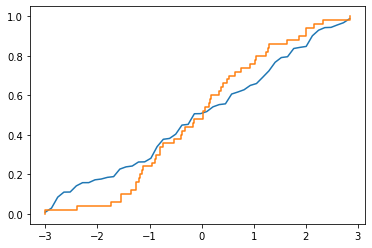

In [44]:
sigma = np.sqrt(error.var())  #np.sqrt(variance_est)
X_ecdf, Y_ecdf = ecdf(error)
Y_error = norm.cdf(np.sort(error), 0, sigma)
delta_f = np.sqrt(N)*(np.max(abs(Y_error.repeat(2)-Y_ecdf)))

plt.plot(np.linspace(min(error), max(error), N), Y_error)
plt.plot(X_ecdf, Y_ecdf)
plt.show()

In [45]:
delta_f

0.5549306222393995

### Парам. бутстрап

In [46]:
delta_arr = np.array([])
for i in range(10000):
    error_i = np.random.normal(0, sigma, size = N)
    m_i, sigma_i = error_i.mean(), error_i.var() 
    Y_error_i = norm.cdf(np.sort(error_i), m_i, sigma_i)
    _, Y_ecdf_i = ecdf(error_i)
    delta_i = np.sqrt(N)*(np.max(abs(Y_error_i.repeat(2)-Y_ecdf_i)))
    delta_arr = np.append(delta_arr, delta_i)

In [47]:
delta_arr.sort()
k_ = sum(delta_arr < delta_f)
k_ += 1

p_value_f = 1 - (k_ - 1)/10000
print(f"p_value  = {p_value_f}")
print('\n Нет оснований отвергнуть H0 о нормальности распределения')

p_value  = 0.8913

 Нет оснований отвергнуть H0 о нормальности распределения


# G - Исследовать регрессию на выбросы

In [48]:
sigma_g = np.median(abs(error))/0.675
row_del = []
N_g = N
for i,e in enumerate(error):
    if e<=-2*sigma_g or e>=2*sigma_g:
        N_g -=1
        row_del.append(i)
        print(i,e)
data_g = np.delete(data, (row_del), axis=0)
target_g = np.delete(target, row_del)
psi_g = np.ones((N_g,1))
psi_g = np.hstack([psi_g, data_g])

F_g = psi_g.T @ psi_g
F_1_g = np.linalg.inv(F_g)
beta_g = F_1_g@psi_g.T @ target_g
rss_g = (target_g - psi_g @ beta_g).T @ (target_g-psi_g @ beta_g)
tss_g = np.sum((target_g-target_g.mean())**2)

12 2.8444725660111407
20 -3.0027840901036402


In [49]:
R_2_g = 1-rss_g/tss_g 
print(f"R2 до удаления выбросов: {R_2}")
print(f"R2 после удаления выбросов:{R_2_g}")

R2 до удаления выбросов: 0.7777442543737277
R2 после удаления выбросов:0.8093128993665363


# H - кросс-проверка регрессии

In [50]:
CV_array = np.array([])
for i in range(N):
    data_h = np.delete(data, i, axis=0)
    target_h = np.delete(target, i)
    psi_h = np.ones((N-1, 1))
    psi_h = np.hstack([psi_h, data_h])
    
    F_h = psi_h.T @ psi_h
    F_1_h = np.linalg.inv(F_h)
    beta_h = F_1_h @ psi_h.T @ target_h
    CV_array = np.append(CV_array, (np.insert(data[i], 0, 1)@beta_h - target[i])**2)
R_cv = 1- np.sum(CV_array)/tss
R_cv

0.7120232171177411

# I - проверить адекватность регрессии

In [51]:
k = 5
teta_arr = np.array([])
for i in range(k):
    teta_arr = np.append(teta_arr, np.random.normal(2+np.sum(coef*1), 1.5))
variance_5 = 1/(k-1)*np.sum((teta_arr - np.mean(teta_arr))**2)
delta_5 = rss/((N-p)*variance_5)

p_value_5 = f.sf(delta_5, N-p, k-1)
print(f"p_value: {p_value_5}")
print('\n Нет оснований отвергнуть H0 о равенстве диспресий')

p_value: 0.1957093676124311

 Нет оснований отвергнуть H0 о равенстве диспресий


# J - удалить переменную, соответствующую наименее значимому коэффициенту и повторить пункты b и c

In [55]:
print('наименее значимый : ', p_value_coef.argmax()) 


наименее значимый :  4


In [59]:
data_j = np.delete(data, p_value_coef.argmax(), axis=1)
psi_j = np.ones((N,1))
psi_j = np.hstack([psi_j, data_j])

F_j = psi_j.T @ psi_j
F_1_j = np.linalg.inv(F_j)
beta_j = F_1_j@psi_j.T @ target
rss_j = (target - psi_j @ beta_j).T @ (target - psi_j @ beta_j)
tss_j = np.sum((target - target.mean())**2)
print(f"{beta_j[0]:.2f} + {beta_j[1]:.2f}x1 + {beta_j[2]:.2f}x2 + {beta_j[3]:.2f}x3 + {beta_j[4]:.2f}x4") 

2.26 + 2.55x1 + -2.76x2 + 1.46x3 + 0.59x4


In [61]:
p_value_coef_j =  np.array([])
for i in range(len(beta_j)):
    delta_j = beta_j[i]/(np.sqrt(rss_j*F_1_j[i,i]))*np.sqrt(N-p)
    p_value_coef_j = np.append(p_value_coef_j, 2*t.sf(abs(delta_j), N-p))
    print(f"p-value for feach {i}: {2*t.sf(abs(delta_j), N-p)}")
print('4ый не значимый')

p-value for feach 0: 6.959060538140691e-14
p-value for feach 1: 5.831891650076406e-10
p-value for feach 2: 3.2885234055161317e-09
p-value for feach 3: 0.00043681606116755797
p-value for feach 4: 0.11193322572430585
4ый не значимый


In [62]:
print(f"коэф. детерминации, после удаления  {(tss_j-rss_j)/tss_j}")

коэф. детерминации, после удаления  0.744501400296687


# K - сравнить ураванения регрессии бутстрапом

In [66]:
# H0 - 4 переменные. # H1 - 5
delta_k = (rss_j - rss)/rss*(N - p)/(p - (p-1))
def get_bootstrap_samples(data, target, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices], target[indices]

delta_k_arr = np.array([])

for i in range(1000):
    data_k, target_k = get_bootstrap_samples(data, target, 1)
    data_k, target_k = data_k[0], target_k[0]
    data_k_5 = np.delete(data_k, p_value_coef.argmax(), axis=1)
    
    psi_k = np.ones((N,1))
    psi_k_5 = np.hstack([psi_k, data_k_5]) # Тут 4 признака и свободный член
    psi_k = np.hstack([psi_k, data_k]) # Тут 5 признаков и свободный член
    
    rss_k = (target_k - psi_k @ beta).T @ (target_k - psi_k @ beta)
    rss_k_5 = (target_k - psi_k_5 @ beta_j).T @ (target_k - psi_k_5 @ beta_j)
    
    delta_k_arr = np.append(delta_k_arr, (rss_k_5 - rss_k)/rss_k*(N - p)/(p - (p-1)))

In [69]:
delta_k_arr.sort()
k_k = sum(delta_k_arr < delta_k)
k_k += 1

p_value_k = 1 - (k_k - 1)/1000
print(f"p_value bootstrap = {p_value_k}")
print('Нет оснований отвергнуть H0 => добавление переменной не значимо')

p_value bootstrap = 0.51
Нет оснований отвергнуть H0 => добавление переменной не значимо
